# Visualizing 2017 Thomas fire scars through false color

Author: Marina Kochuten

Repository: https://github.com/marinakochuten/eds220-hwk4

## About

The Thomas Fire, which burned over 280,000 acres in Ventura and Santa Barbara counties in December 2017, was one of California’s largest wildfires at the time. It caused widespread ecological damage, displaced communities, and left lasting environmental impacts.

False color imagery, created using satellite data from instruments like Landsat, is a useful tool for monitoring wildfire impacts. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars.

In this notebook, I create a false color image of the Thomas Fire using Landsat remote sensing data, highlighting the fire scar and exploring how coding and data visualization support environmental monitoring.

### Highlights

- Data exploration with `rioxarray`
- Use remote sensing data to create false color imagery
- Creating and customizing a visualization with raster and vector data symbolized together

### Data

**About the data:** I use a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was retrieved from the Microsoft Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution. This data is intended for visualization and educational purposes only.

**Citation:** Microsoft Planetary Computer data catalogue (2024), *Landsat Collection 2 Level-2 (simplified)* [Data set] Available from: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Access date: November 18, 2024.

## Import libraries

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches                # For creating custom legend
from matplotlib_scalebar.scalebar import ScaleBar    # For adding scalebar 

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

## Data exploration

In [2]:
# Construct file path to Landsat data
fp = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'hwk4_landsat_data',
                  'landsat8-2018-01-26-sb-simplified.nc')

# Import Landsat data
landsat = rioxr.open_rasterio(fp)

# Import Thomas Fire boundary for later visualization
thomas_boundary = gpd.read_file('data/thomas_fire_boundary.geojson')

In [3]:
# Look at the landsat raster
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

**Preliminary summary:** The Landsat data is a xarray.Dataset with 3 dimensions: band, x, and y. It contains five variables: red, green, blue, nir08, and swir 22. Each variable uses all 3 dimensions: band, x, and y. Note that the band dimension only has one layer, making it redundant. The data is in the CRS EPSG:32611. 

## Prepare data

Before starting analysis, I drop the unnecessary band dimension and associated coordinates:

In [4]:
# Drop redundant band dimension
landsat = landsat.squeeze().drop_vars('band')
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

Now that I have a simplified, 2D raster, I am ready to start analysis and visualization.

## Analysis

### True color image

Create RBG image with the Landsat data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


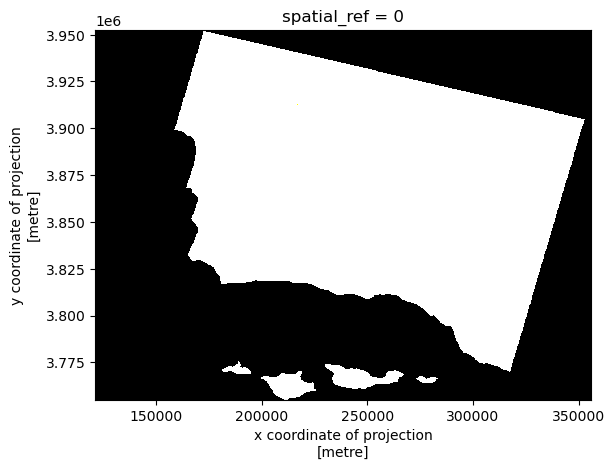

In [5]:
# Select the red, green, and blue variables, convert to array, and plot image
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. I now adjust the scale to deal with this issue using the parameter `robust = True`

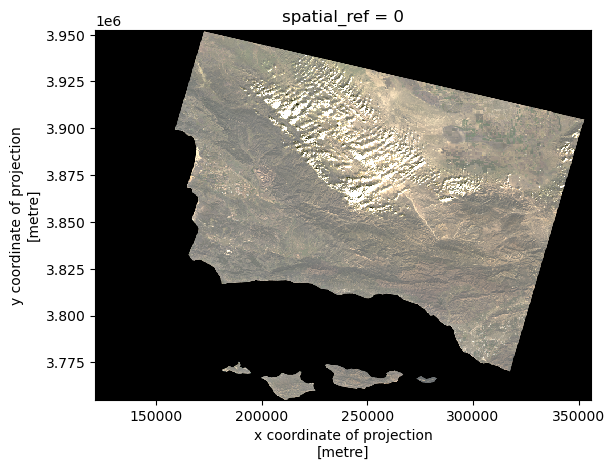

In [6]:
# Adjust the scale used for plotting the bands to get a true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

By setting `robust = True` in `imshow()`, I adjust the display of the image to handle color scaling appropriately by ignoring the outlier RBG values caused by clouds. It fixed the contrast issue that's seen in the first image (causing it to appear bright white), and now I have a true color image from our Landsat data that can be interpreted (the second image).

### False color image

Create a false color image with the Landsat data:

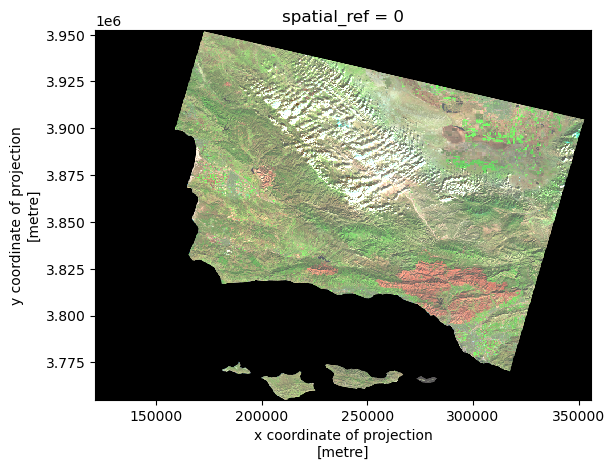

In [7]:
# Select the shortwave infrared, near infrared, and red variables, convert to array, and plot
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

This false color image uses the shortwave infrared and near infrared to easily visualize bare ground / burned areas (shown in red) and vegetation (shown in bright green).

### Map

Now, I create a map showing the false color image together with the Thomas Fire perimeter to visualize fire scars.

In [8]:
# Before the two spatial objects can interact, I need to match the CRSs
thomas_boundary = thomas_boundary.to_crs(landsat.rio.crs)
assert thomas_boundary.crs == landsat.rio.crs

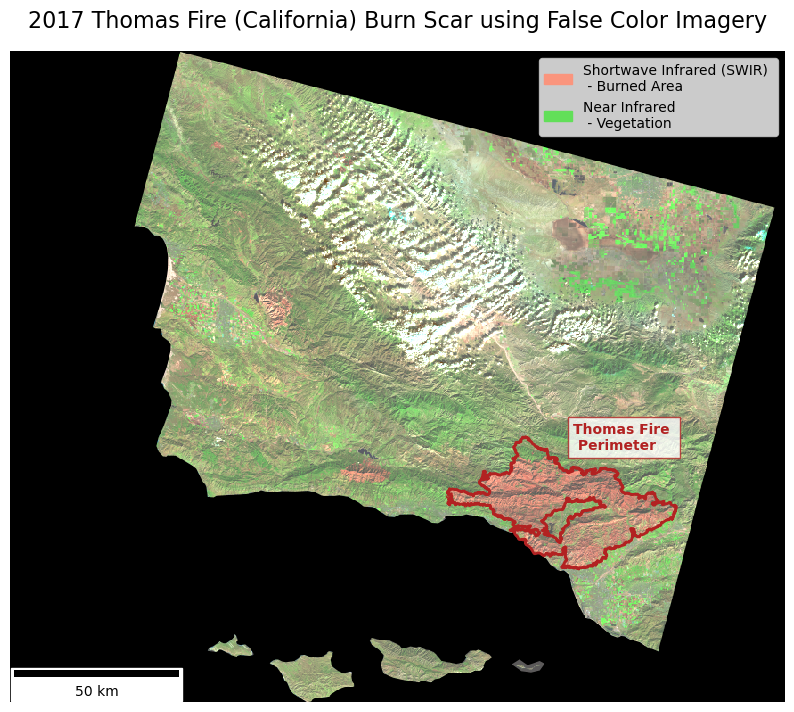

In [9]:
# Create an object containing the aspect ratio for the landsat map
ratio = landsat.rio.width / landsat.rio.height

# Initialize plot
fig, ax = plt.subplots(figsize = (10, 10 * ratio))  # Update figure size and aspect

# Remove axis for cleaner map
ax.axis('off')

# Plot false color image
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax, zorder = 1)

# Create custom legend items for false color image bands
legend_swir = mpatches.Patch(color = "#FA957D", label = 'Shortwave Infrared (SWIR) \n - Burned Area')
legend_nir = mpatches.Patch(color = "#62DF59", label = 'Near Infrared \n - Vegetation')

# Plot legend
ax.legend(handles = [legend_swir, legend_nir], loc = 'upper right', fontsize = 10)

# Plot Thomas Fire perimeter
thomas_boundary.plot(ax = ax, 
                     edgecolor = 'firebrick',
                     color = 'none',
                     linewidth = 2,
                     zorder = 2,
                     legend = True)

# Add fire perimeter label
ax.text(x = 291870, y = 3831700,         # Position coordinates
        s = "Thomas Fire \n Perimeter",  # Label text
        fontsize = 10, 
        weight = 'bold',
        color = 'firebrick',
        bbox = dict(facecolor = 'white', edgecolor = 'firebrick', alpha = 0.8, pad = 4))   # Box behind text for visibility

# Title for the plot
ax.set_title('2017 Thomas Fire (California) Burn Scar using False Color Imagery', fontsize = 16)

# Add scale bar 
scalebar = ScaleBar(1, units='m', location='lower left', length_fraction=0.25, color='black')  
ax.add_artist(scalebar)

# Display the plot
plt.show()

This map uses false color imagery to highlight the 2017 Thomas Fire's burn scar in Santa Barbara and Ventura counties (California). In this image, I use Landsat's shortwave infrared, near infrared, and green bands to visualize the burn. Newly burned land reflects strongly in SWIR bands, making the burn scar appear red in my map. The bright green shows vegetation, as it reflects near infrared light very strongly. 